# Task 3: Multimodal Housing Price Prediction
Combine image + tabular data for regression.


In [1]:
# Install packages (run once)
!pip install -q tensorflow keras pandas scikit-learn matplotlib pillow


In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam


In [3]:
# Number of samples
N = 50

# Synthetic tabular features
np.random.seed(42)
df = pd.DataFrame({
    "bedrooms": np.random.randint(1, 6, N),
    "bathrooms": np.random.randint(1, 4, N),
    "sqft_living": np.random.randint(500, 4000, N),
    "price": np.random.randint(100000, 1000000, N),
})

# Synthetic images as random noise (128x128 RGB)
IMG_SIZE = (128, 128)
X_img = np.random.rand(N, IMG_SIZE[0], IMG_SIZE[1], 3)

# Tabular features
tabular_features = ["bedrooms", "bathrooms", "sqft_living"]
X_tab = df[tabular_features].values
y = df["price"].values


In [4]:

scaler = StandardScaler()
X_tab = scaler.fit_transform(X_tab)


In [5]:

X_tab_train, X_tab_test, X_img_train, X_img_test, y_train, y_test = train_test_split(
    X_tab, X_img, y, test_size=0.2, random_state=42
)
print("Tabular train:", X_tab_train.shape, "Tabular test:", X_tab_test.shape)
print("Image train:", X_img_train.shape, "Image test:", X_img_test.shape)

Tabular train: (40, 3) Tabular test: (10, 3)
Image train: (40, 128, 128, 3) Image test: (10, 128, 128, 3)


In [6]:
# Image input
img_input = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = Conv2D(32, (3,3), activation='relu')(img_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

img_features = x


In [7]:
# Tabular input
tab_input = Input(shape=(X_tab_train.shape[1],))

# Combine features
combined = Concatenate()([img_features, tab_input])
combined = Dense(128, activation='relu')(combined)
combined = Dense(64, activation='relu')(combined)
output = Dense(1, activation='linear')(combined)  # regression output

# Full model
model = Model(inputs=[img_input, tab_input], outputs=output)
model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 57600)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  7,372,928 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 131)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,417,537 (28.30 MB)

 Trainable params: 7,417,537 (28.30 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=8,
    verbose=2
)


Epoch 1/50
4/4 - 7s - 2s/step - loss: 322545123328.0000 - mae: 504815.5625 - val_loss: 416536559616.0000 - val_mae: 574340.5000
Epoch 2/50
4/4 - 4s - 1s/step - loss: 322376499200.0000 - mae: 504653.5000 - val_loss: 416134791168.0000 - val_mae: 573990.5625
Epoch 3/50
4/4 - 1s - 257ms/step - loss: 321728446464.0000 - mae: 504044.6875 - val_loss: 414750539776.0000 - val_mae: 572783.3750
Epoch 4/50
4/4 - 1s - 246ms/step - loss: 319888097280.0000 - mae: 502180.0625 - val_loss: 410964590592.0000 - val_mae: 569468.5000
Epoch 5/50
4/4 - 1s - 251ms/step - loss: 314364690432.0000 - mae: 497062.5312 - val_loss: 401498898432.0000 - val_mae: 561095.1250
Epoch 6/50
4/4 - 1s - 251ms/step - loss: 303022440448.0000 - mae: 484836.0625 - val_loss: 380129312768.0000 - val_mae: 541716.2500
Epoch 7/50
4/4 - 1s - 317ms/step - loss: 280271912960.0000 - mae: 458776.8438 - val_loss: 336424894464.0000 - val_mae: 499748.5625
Epoch 8/50
4/4 - 2s - 505ms/step - loss: 233112715264.0000 - mae: 402644.7188 - val_loss:

In [9]:
# Predict on test set
y_pred = model.predict([X_img_test, X_tab_test])

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
Test MAE: 202912.23
Test RMSE: 267010.29


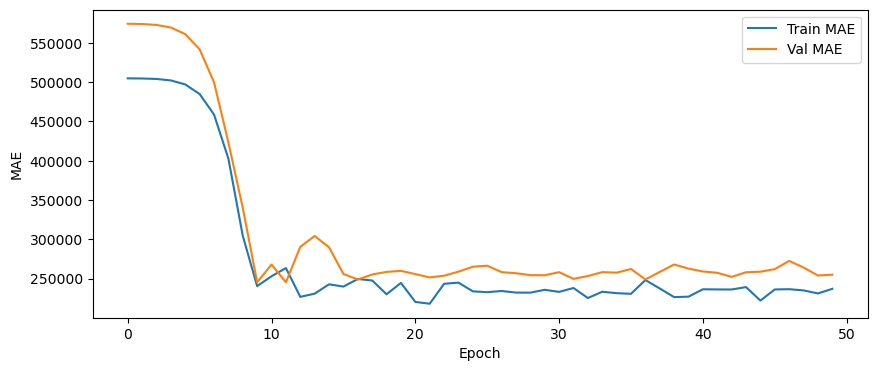

In [10]:
plt.figure(figsize=(10,4))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()
